# GMM-based voice conversion (en)

In this notebook, we demonstrate how to build a traditional one-to-one GMM-based voice conversion system. You will learn how to implement voice conversion and how Maximum Likelihood Parameter Generation (MLPG) works though the notebook. Details about GMM-based voice conversion can be found at:

- T. Toda, A. W. Black, and K. Tokuda, “Voice conversion based on maximum likelihood estimation of spectral parameter trajectory,” IEEETrans. Audio, Speech, Lang. Process, vol. 15, no. 8, pp. 2222–2235, Nov. 2007.

In this demo, we use differencial spectrum modification technique to get high speech quality described in the following paper:

- Kobayashi, Kazuhiro, et al. "Statistical Singing Voice Conversion with Direct Waveform Modification based on the Spectrum Differential." Fifteenth Annual Conference of the International Speech Communication Association. 2014.

To run the demonstration notebook, in addition to nnmnkwii and its dependencies, you will need the following packages:

- pytorch: http://pytorch.org/
- pysptk: https://github.com/r9y9/pysptk
- pyworld: https://github.com/JeremyCCHsu/Python-Wrapper-for-World-Vocoder
- librosa: https://github.com/librosa/librosa
- tqdm: https://github.com/tqdm/tqdm

Please make sure that you have all dependneices if you are trying to run the notebook locally.

```
pip install pysptk pyworld librosa tqdm
```

Also, please download [CMU ARCTIC dataset](http://www.festvox.org/cmu_arctic/) and configure `DATA_ROOT` to point where you have data.


In [1]:
from os.path import join, expanduser
DATA_ROOT = join(expanduser("~"), "data", "cmu_arctic")
!ls $DATA_ROOT

cmu_us_awb_arctic  cmu_us_clb_arctic  cmu_us_ksp_arctic  cmu_us_slt_arctic
cmu_us_bdl_arctic  cmu_us_jmk_arctic  cmu_us_rms_arctic


Each sub directiory inside `DATA_ROOT` must have `wav` directory.

In [2]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os.path import basename, splitext
import sys
import time

import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


## Data

In typical one-to-one voice conversion, we need time-aligned source and target speaker's features. In the demo, we use mel-cepstrum as spectral feature representation and try to convert source speaker's feature to that of target speaker. 

For GMM-based conversion, we need joint feature matrix, which is composed of time-aligned source and target features. Steps to prepare dataset are:

- Compute features for each speaker
- Align features by Dynamic time warping (DTW) for each utterance.
- (GMM voice convertion only) Combine source and target features.

### Data specification

In [3]:
fs = 16000
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
order = 24
frame_period = 5
hop_length = int(fs * (frame_period * 0.001))
max_files = 100 # number of utterances to be used.
test_size = 0.03
use_delta = True

if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

### File data sources

We need to specify 1) where to find source files and 2) how to process them. In this case,

1. `collect_files` : Collects `.wav` files. Also we split the files into train/test set.
2. `collect_features` : Loads wav file and compute mel-cepstrum.

For CMU ARCTIC case, we can use built-in data source `CMUArcticWavFileDataSource` to collects wav files. However, you can do it manually pretty easily.

In [4]:
class MyFileDataSource(CMUArcticWavFileDataSource):
    def __init__(self, *args, **kwargs):
        super(MyFileDataSource, self).__init__(*args, **kwargs)
        self.test_paths = None

    def collect_files(self):
        paths = super(
            MyFileDataSource, self).collect_files()
        paths_train, paths_test = train_test_split(
            paths, test_size=test_size, random_state=1234)

        # keep paths for later testing
        self.test_paths = paths_test

        return paths_train

    def collect_features(self, path):
        fs, x = wavfile.read(path)
        x = x.astype(np.float64)
        f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
        f0 = pyworld.stonemask(x, f0, timeaxis, fs)
        spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
        spectrogram = trim_zeros_frames(spectrogram)
        mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
        return mc

We choose `clb` as source speaker and `slt` as target speaker, respectively. To align source and target datasets later, define data sources separately.

In [5]:
clb_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["clb"], max_files=max_files)
slt_source = MyFileDataSource(data_root=DATA_ROOT,
                                         speakers=["slt"], max_files=max_files)

### Convert dataset to arrays

Since we are using small dataset, it's enough to load entire dataset into memory at once. To handle variable-length frame lengths, we use `PaddedFileSourceDataset` here.

In [6]:
X = PaddedFileSourceDataset(clb_source, 1200).asarray()
Y = PaddedFileSourceDataset(slt_source, 1200).asarray()
print(X.shape)
print(Y.shape)

(97, 1200, 25)
(97, 1200, 25)


### How data look like?

Pick an utterance pair and visualize features.

In [7]:
# Plotting util
def plot_parallel(x,y):
    figure(figsize=(16,7))
    subplot(2,1,1)
    librosa.display.specshow(trim_zeros_frames(x).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()
    subplot(2,1,2)
    librosa.display.specshow(trim_zeros_frames(y).T, sr=fs, hop_length=hop_length, x_axis="time")
    colorbar()

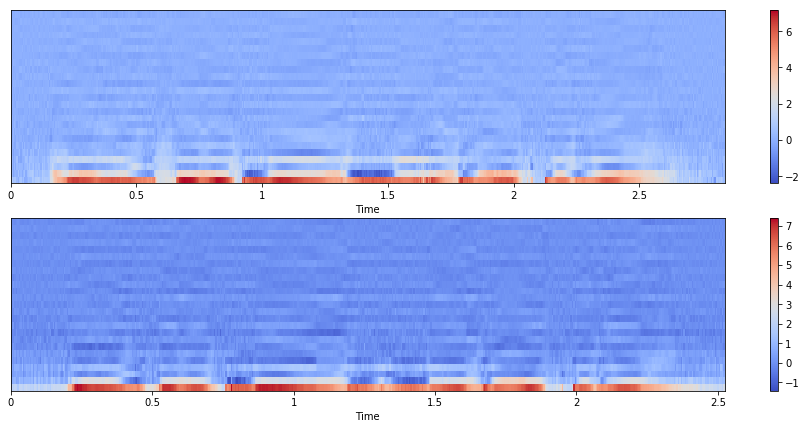

In [8]:
idx = 22 # any 
plot_parallel(X[idx],Y[idx])

### Align source and target features

We can use `nnmnkwii.preprocessing.DTWAligner`

In [9]:
# Alignment
X_aligned, Y_aligned = DTWAligner(verbose=0, dist=melcd).transform((X, Y))

### How parallel data look like?

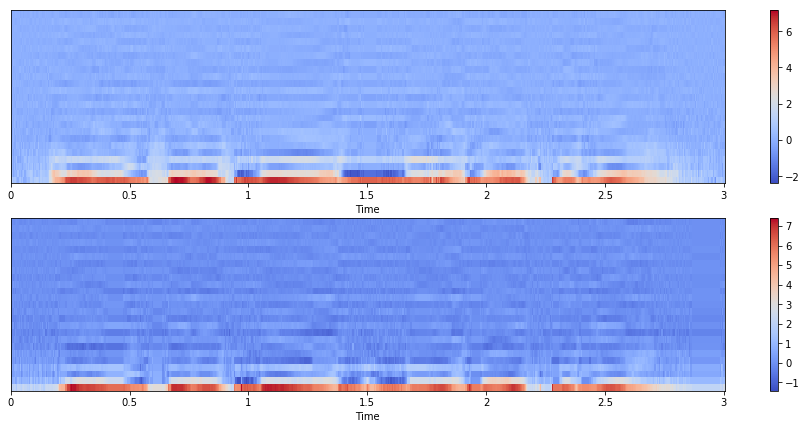

In [10]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

0-th mel-cesptrum is a power coefficient by definition. Since we want to focus on spectral characteristics, drop 1-st dimension from aligned features.

In [11]:
# Drop 1st (power) dimension
X_aligned, Y_aligned = X_aligned[:, :, 1:], Y_aligned[:, :, 1:]

### Append delta features

It's well known that delta features improve generated speech quality. Later we can use the delta features to sequence-wise parameter generation; a.k.a Maximum Likelihood Parameter Generation (MLPG).

In [12]:
static_dim = X_aligned.shape[-1]
if use_delta:
    X_aligned = apply_each2d_trim(delta_features, X_aligned, windows)
    Y_aligned = apply_each2d_trim(delta_features, Y_aligned, windows)

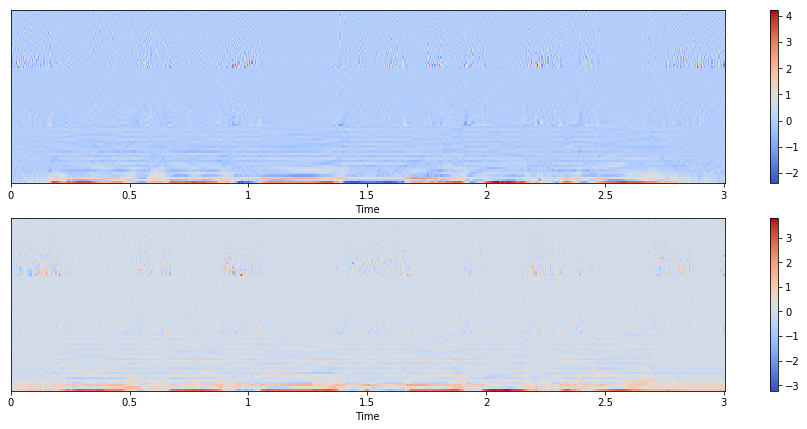

In [13]:
plot_parallel(X_aligned[idx],Y_aligned[idx])

### Finally, we get joint feature matrix

As we represent features in numpy arrays, it's very easy to combine them.

In [14]:
XY = np.concatenate((X_aligned, Y_aligned), axis=-1).reshape(-1, X_aligned.shape[-1]*2)
print(XY.shape)

(116400, 144)


Note that we padded zeros to data. Removes zeros frames to speed-up training. 

In [15]:
XY = remove_zeros_frames(XY)
print(XY.shape)

(68194, 144)


## Model

We use `sklearn.mixture.GaussianMixture`. `sklearn.mixture.BayesianGaussianMixture` can also be used as an drop-in replacement.

In [16]:
gmm = GaussianMixture(
    n_components=64, covariance_type="full", max_iter=100, verbose=1)

%time gmm.fit(XY)

Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
Initialization converged: True
CPU times: user 38min 6s, sys: 3min 23s, total: 41min 29s
Wall time: 10min 32s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=64, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

### Visualize model

Let's see paramters of GMMs.

#### Means

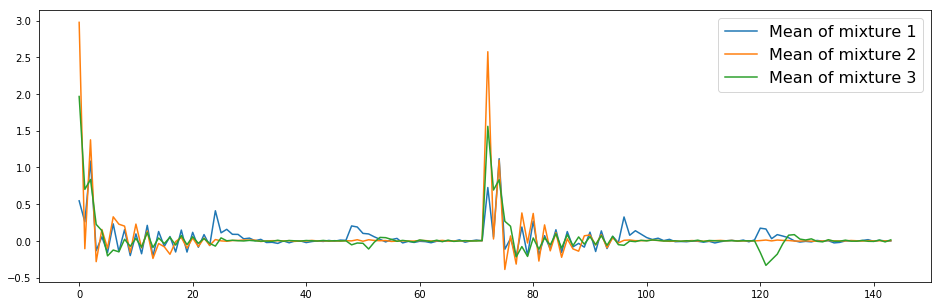

In [17]:
for k in range(3):
    plot(gmm.means_[k], linewidth=1.5, label="Mean of mixture {}".format(k+1))
legend(prop={"size": 16})

#### Covariances

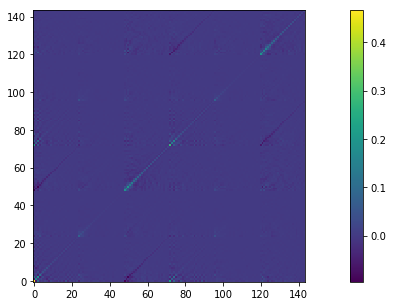

In [18]:
imshow(gmm.covariances_[0], origin="bottom left")
colorbar()

Digonal part of covariance matrix, which is expected to be dominant.

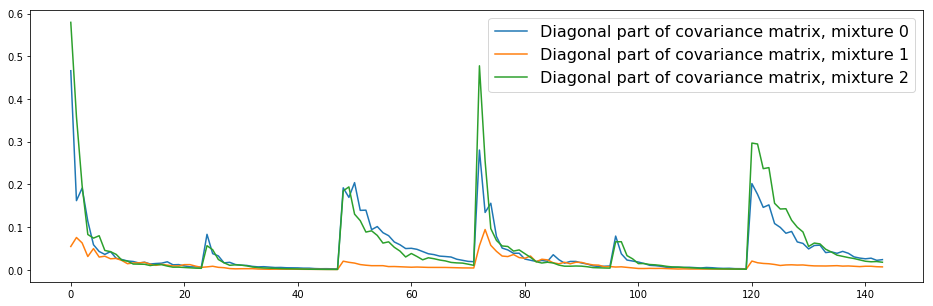

In [19]:
for k in range(3):
    plot(np.diag(gmm.covariances_[k]), linewidth=1.5, 
         label="Diagonal part of covariance matrix, mixture {}".format(k))
legend(prop={"size": 16})

## Test

Once we trained GMMs, we can perform parameter generation using MLPG.

In [20]:
def test_one_utt(src_path, tgt_path, disable_mlpg=False, diffvc=True):
    # GMM-based parameter generation is provided by the library in `baseline` module
    if disable_mlpg:
        # Force disable MLPG
        paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    else:
        paramgen = MLPG(gmm, windows=windows, diff=diffvc)

    fs, x = wavfile.read(src_path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    if use_delta:
        mc = delta_features(mc, windows)
    mc = paramgen.transform(mc)
    if disable_mlpg and mc.shape[-1] != static_dim:
        mc = mc[:,:static_dim]
    assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))
    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, fs, frame_period)
        
    return waveform

### Listen results

Let's compare the following four different samples. Last two are converted ones. MLPG should avoid temporal discontinuity of parameter sequence and can produce less-noisy speech.

- Source speech
- Target speech
- Converted speech (w/o MLPG)
- Converted speech (w/ MLPG)

In [21]:
for i, (src_path, tgt_path) in enumerate(zip(clb_source.test_paths, slt_source.test_paths)):
    print("{}-th sample".format(i+1))
    wo_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=True)
    w_MLPG = test_one_utt(src_path, tgt_path, disable_mlpg=False)
    _, src = wavfile.read(src_path)
    _, tgt = wavfile.read(tgt_path)
    
    print("Source:", basename(src_path))
    IPython.display.display(Audio(src, rate=fs))
    print("Target:", basename(tgt_path))
    IPython.display.display(Audio(tgt, rate=fs))
    print("w/o MLPG")
    IPython.display.display(Audio(wo_MLPG, rate=fs))
    print("w/ MLPG")
    IPython.display.display(Audio(w_MLPG, rate=fs))

1-th sample
Source: arctic_a0041.wav


Target: arctic_a0041.wav


w/o MLPG


w/ MLPG


2-th sample
Source: arctic_a0036.wav


Target: arctic_a0036.wav


w/o MLPG


w/ MLPG


3-th sample
Source: arctic_a0082.wav


Target: arctic_a0082.wav


w/o MLPG


w/ MLPG


### How different?

In [22]:
def vis_difference(x, y, which_dims=[0,2,3,6,8], T_max=None):
    static_paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=False)
    paramgen = MLPG(gmm, windows=windows, diff=False)

    x = trim_zeros_frames(x)
    y = trim_zeros_frames(y)[:,:static_dim]
    y_hat1 = static_paramgen.transform(x)[:,:static_dim]
    y_hat2 = paramgen.transform(x)

    if T_max is not None and len(y) > T_max:
        y,y_hat1,y_hat2 = y[:T_max],y_hat1[:T_max],y_hat2[:T_max]
        
    figure(figsize=(16,4*len(which_dims)))
    for idx, which_dim in enumerate(which_dims):
        subplot(len(which_dims), 1, idx+1)
        plot(y[:,which_dim], "--", linewidth=1, label="Target")
        plot(y_hat1[:,which_dim], "-", linewidth=2, label="w/o MLPG")
        plot(y_hat2[:,which_dim], "-", linewidth=3, label="w/ MLPG")
        title("{}-th coef".format(which_dim+1), fontsize=16)
        legend(prop={"size": 16}, loc="upper right")

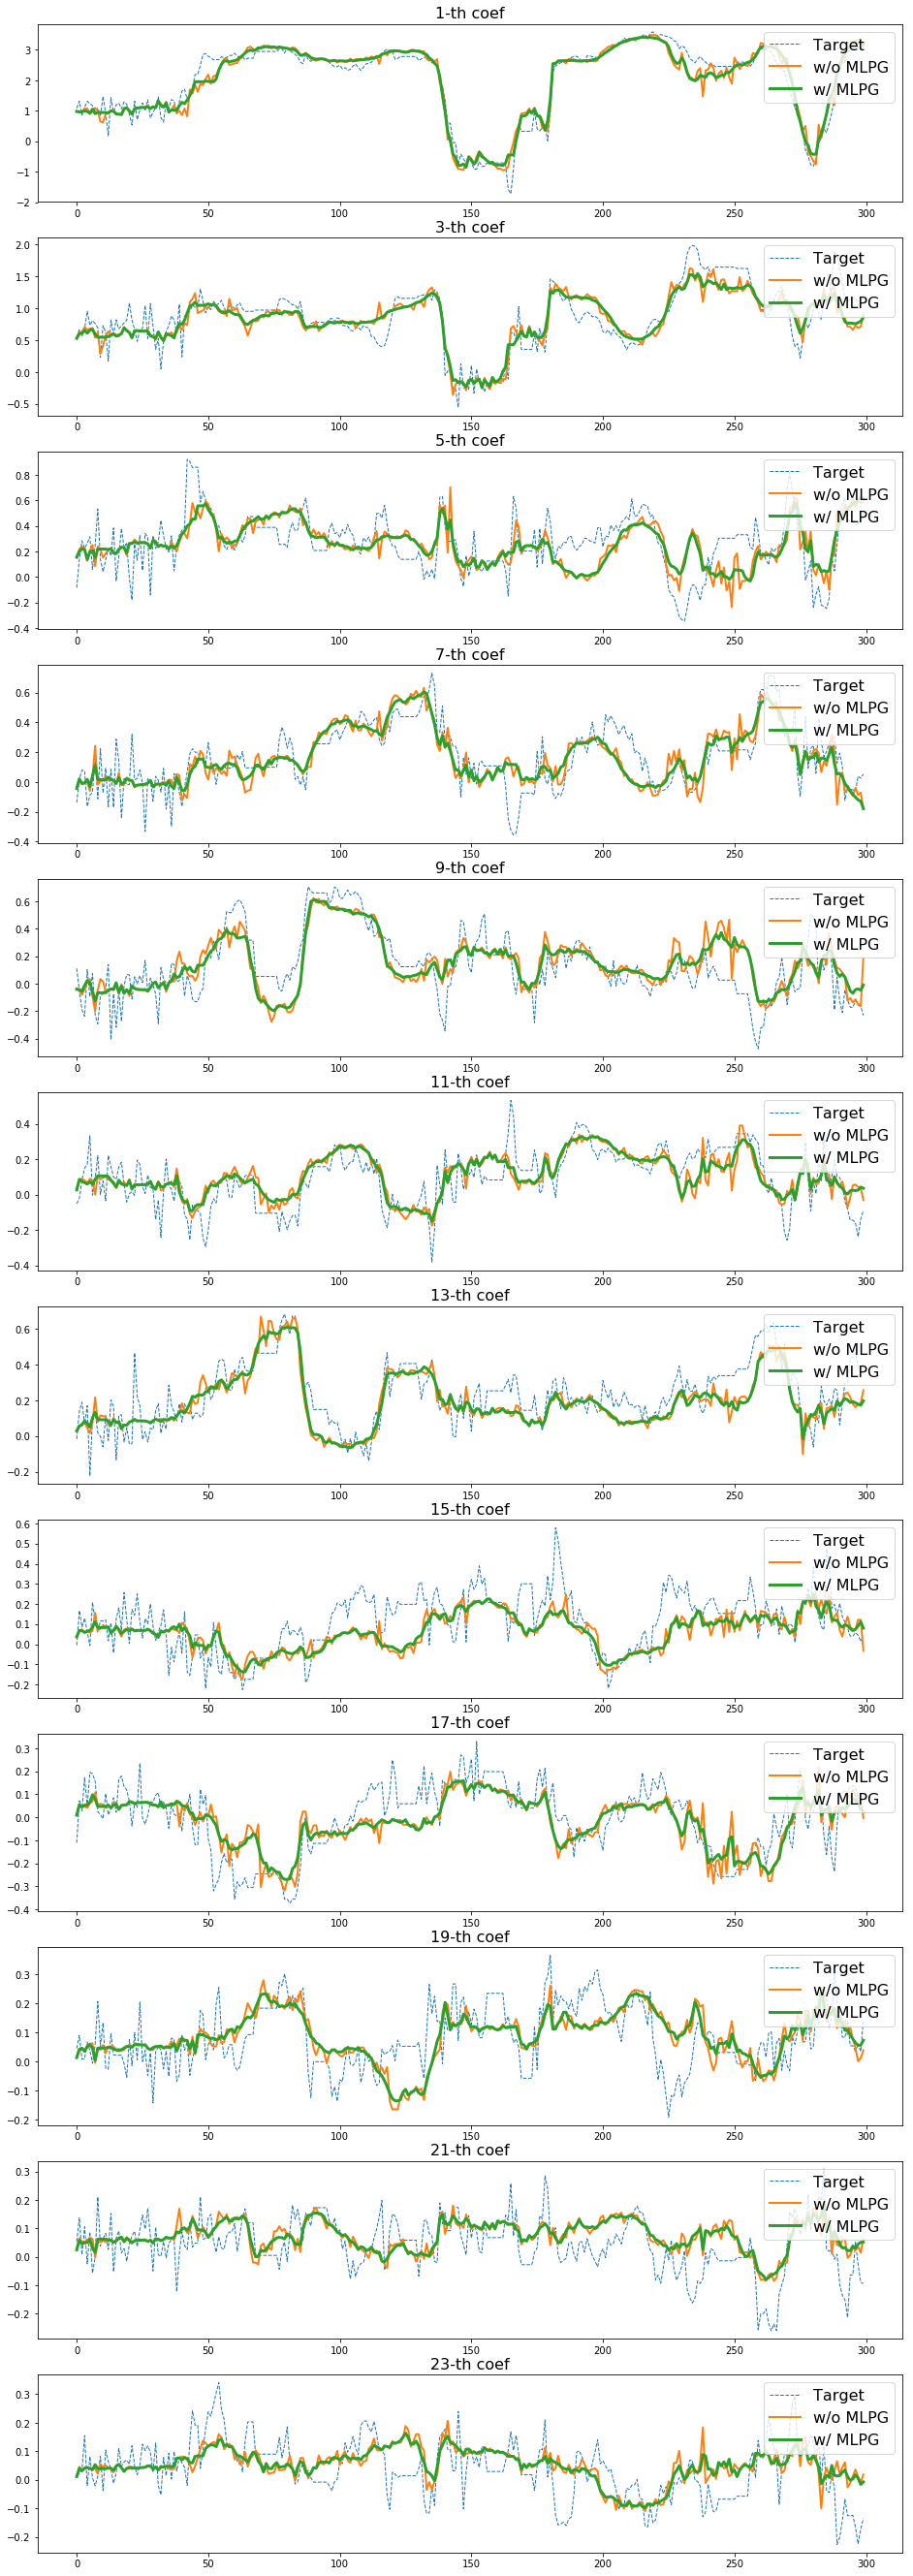

In [23]:
idx = 0
which_dims = np.arange(0, static_dim, step=2)
vis_difference(X_aligned[idx], Y_aligned[idx], T_max=300, which_dims=which_dims)